In [1]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
import pickle
import numpy as np
import pandas as pd 

csv_directory = '/Users/aimee/Documents/College/Courses/S24/17-735/17735-project/ExtractedData'

def dtt2timestamp(dtt):
  time_in_sec = (dtt.hour*60 + dtt.minute) * 60 + dtt.second
  return time_in_sec

In [2]:
# Lists to hold data from each file
logon_data = []
logoff_data = []

# Iterate over each CSV file in the directory
for filename in os.listdir(csv_directory):
    if filename.endswith('.csv'):
        # Full path to the CSV file
        csv_path = os.path.join(csv_directory, filename)

        # Read the CSV file into a DataFrame
        df = pd.read_csv(csv_path, names=['User', 'Timestamp', 'PC', 'ActivityType', 'Action'])

        # Convert Timestamp to datetime
        df['Timestamp'] = pd.to_datetime(df['Timestamp'], format='%m/%d/%Y %H:%M:%S')

        # Extract time and hour from Timestamp
        df['Time'] = df['Timestamp'].dt.time
        df['Hour'] = df['Timestamp'].dt.hour

        # Append DataFrame to the list by action
        logon_data.append(df[df['Action'] == 'Logon'])
        logoff_data.append(df[df['Action'] == 'Logoff'])

# Concatenate all logon and logoff data into two separate DataFrames
logon_df = pd.concat(logon_data)
logoff_df = pd.concat(logoff_data)

# Split the data so that 80% is used for model training, 20% for testing
logon_train_df, logon_test_df = train_test_split(logon_df, test_size=0.2)
logoff_train_df, logoff_test_df = train_test_split(logoff_df, test_size=0.2)


In [3]:
# Creating training data

# Group by 'User' and aggregate times for logon
df_user_logon_stats = logon_train_df.groupby('User')['Time'].agg(['min', 'max']).reset_index()
df_logon_mode = logon_train_df.groupby('User')['Time'].agg(lambda x: x.value_counts().index[0]).reset_index()
df_logon_mean = logon_train_df.groupby('User')['Hour'].mean().reset_index()

# Convert mean hour to int and then to time
df_logon_mean['Hour'] = df_logon_mean['Hour'].astype(int)
df_logon_mean['Hour'] = pd.to_datetime(df_logon_mean['Hour'], format='%H').dt.time

# Add mode and mean to the logon stats DataFrame
df_user_logon_stats['mode'] = df_logon_mode['Time']
df_user_logon_stats['mean'] = df_logon_mean['Hour']

# Group by 'User' and aggregate times for logoff
df_user_logoff_stats = logoff_train_df.groupby('User')['Time'].agg(['min', 'max']).reset_index()
df_logoff_mode = logoff_train_df.groupby('User')['Time'].agg(lambda x: x.value_counts().index[0]).reset_index()
df_logoff_mean = logoff_train_df.groupby('User')['Hour'].mean().reset_index()

# Convert mean hour to int and then to time
df_logoff_mean['Hour'] = df_logoff_mean['Hour'].astype(int)
df_logoff_mean['Hour'] = pd.to_datetime(df_logoff_mean['Hour'], format='%H').dt.time

# Add mode and mean to the logoff stats DataFrame
df_user_logoff_stats['mode'] = df_logoff_mode['Time']
df_user_logoff_stats['mean'] = df_logoff_mean['Hour']

In [4]:
df_user_logon_stats_sec = df_user_logon_stats

time_columns = ['min', 'max', 'mode', 'mean']
for col in time_columns:
    df_user_logon_stats_sec[col] = pd.to_datetime(df_user_logon_stats[col], format='%H:%M:%S').dt.time


min_ts = [dtt2timestamp(dtt) for dtt in df_user_logon_stats_sec['min']]
max_ts = [dtt2timestamp(dtt) for dtt in df_user_logon_stats_sec['max']]
mode_ts = [dtt2timestamp(dtt) for dtt in df_user_logon_stats_sec['mode']]
mean_ts = [dtt2timestamp(dtt) for dtt in df_user_logon_stats_sec['mean']]

df_user_logon_stats_sec['min_ts'] = min_ts
df_user_logon_stats_sec['max_ts'] = max_ts
df_user_logon_stats_sec['mode_ts'] = mode_ts
df_user_logon_stats_sec['mean_ts'] = mean_ts


df_user_logon_stats_sec.drop(['min','max','mode','mean'], axis=1)

df_user_logoff_stats_sec = df_user_logoff_stats

for col in time_columns:
    df_user_logoff_stats_sec[col] = pd.to_datetime(df_user_logoff_stats[col], format='%H:%M:%S').dt.time


min_ts = [dtt2timestamp(dtt) for dtt in df_user_logoff_stats_sec['min']] 
max_ts = [dtt2timestamp(dtt) for dtt in df_user_logoff_stats_sec['max']]
mode_ts = [dtt2timestamp(dtt) for dtt in df_user_logoff_stats_sec['mode']]
mean_ts = [dtt2timestamp(dtt) for dtt in df_user_logoff_stats_sec['mean']]


df_user_logoff_stats_sec['min_ts'] = min_ts
df_user_logoff_stats_sec['max_ts'] = max_ts
df_user_logoff_stats_sec['mode_ts'] = mode_ts
df_user_logoff_stats_sec['mean_ts'] = mean_ts


df_user_logoff_stats_sec.drop(['min', 'max','mode','mean'], axis=1)


df_log_on_off_stats = pd.DataFrame()

df_log_on_off_stats['User'] = df_user_logon_stats_sec['User']
df_log_on_off_stats['on_min_ts'] = df_user_logon_stats_sec['min_ts']
df_log_on_off_stats['on_max_ts'] = df_user_logon_stats_sec['max_ts']
df_log_on_off_stats['on_mode_ts'] = df_user_logon_stats_sec['mode_ts']
df_log_on_off_stats['on_mean_ts'] = df_user_logon_stats_sec['mean_ts']
df_log_on_off_stats['off_min_ts'] = df_user_logon_stats_sec['min_ts']
df_log_on_off_stats['off_max_ts'] = df_user_logon_stats_sec['max_ts']
df_log_on_off_stats['off_mode_ts'] = df_user_logon_stats_sec['mode_ts']
df_log_on_off_stats['off_mean_ts'] = df_user_logon_stats_sec['mean_ts']


log_stats = df_log_on_off_stats.drop(['User'], axis=1)
log_stats_array = np.array(log_stats)  # Changed from np.matrix to np.array
print(log_stats_array)

[[27301 49617 28461 ... 49617 28461 32400]
 [28203 29393 28898 ... 29393 28898 25200]
 [28203 29393 28588 ... 29393 28588 25200]
 ...
 [23700 59713 24294 ... 59713 24294 28800]
 [30005 31186 30269 ... 31186 30269 28800]
 [32706 33894 32954 ... 33894 32954 32400]]


In [5]:
import diffprivlib
from diffprivlib.accountant import BudgetAccountant
from diffprivlib.utils import PrivacyLeakWarning
from diffprivlib.mechanisms import PermuteAndFlip
from diffprivlib.validation import DiffprivlibMixin

In [6]:
import numpy as np
import math

class IsolationForestCustom:
    def __init__(self, n_estimators=100, max_samples='auto', max_depth=1, contamination=0.1, random_state=None, epsilon=0.1, accountant=None):
        self.n_estimators = n_estimators
        self.max_samples = max_samples
        self.max_depth = max_depth
        self.contamination = contamination
        self.random_state = random_state
        self.epsilon = epsilon
        self.test_data_size = 0
        self.trees = []
        self.accountant = BudgetAccountant.load_default(accountant)

    def fit(self, X):
        self.accountant.check(self.epsilon, 0)

        num_samples, num_features = X.shape
        self.test_data_size = num_samples
        self.max_samples = self.max_samples if self.max_samples != 'auto' else min(256, num_samples)

        for _ in range(self.n_estimators):
            idx = np.random.choice(num_samples, size=self.max_samples, replace=False)
            tree = self._fit_tree(X[idx], max_depth=self.max_depth)
            self.trees.append(tree)
        
        self.accountant.spend(self.epsilon, 0)

    def _fit_tree(self, X, max_depth):
        if max_depth <= 0 or len(X) <= 1:
            return {'isLeaf': True,
                    'size': len(X)
            }
        num_samples, num_features = X.shape
        feature_idx = np.random.randint(0, num_features)
        split_val = np.random.uniform(X[:, feature_idx].min(), X[:, feature_idx].max())
        
        left_idxs = X[:, feature_idx] < split_val
        right_idxs = ~left_idxs
        
        left_subtree = self._fit_tree(X[left_idxs], max_depth - 1)
        right_subtree = self._fit_tree(X[right_idxs], max_depth - 1)

        return {
            'isLeaf': False,
            'feature_idx': feature_idx,
            'split_val': split_val,
            'left': left_subtree,
            'right': right_subtree
        }

    def c(self, sample_size):
        if (sample_size < 2):
            return 0
        elif (sample_size == 2):
            return 1
        return 2.0 * (math.log(sample_size - 1) + 0.5772156649) - 2.0 * (sample_size - 1) / self.test_data_size

    def predict(self, X):
        num_samples = len(X)
        anomaly_scores = np.zeros(num_samples)
        
        for i, sample in enumerate(X):
            for j, tree in enumerate(self.trees):
                anomaly_scores[i] += self._path_length(sample, tree)
            anomaly_scores[i] = 0.5 - 2 ** (-anomaly_scores[i] / self.n_estimators / self.c(self.max_samples))

        return anomaly_scores

    def _path_length(self, x, tree):
        current_node = tree  # Start from the root node
        path_length = 0
        
        while True:
            if 'size' in current_node:
                return path_length + self.c(current_node['size'])
            feature_idx = current_node['feature_idx']
            split_val = current_node['split_val']
            
            if x[feature_idx] < split_val:  # Traverse left
                current_node = current_node['left']
            else:  # Traverse right
                current_node = current_node['right']
                    
                    
            path_length += 1

In [7]:
accountant = BudgetAccountant(epsilon=0.1)

# Example usage:
# Assuming X_train is your training data
iforest_custom = IsolationForestCustom(n_estimators=100, contamination=0.1, epsilon=0.1, accountant=accountant)
iforest_custom.fit(log_stats_array)

In [8]:
# Creating testing data

# Group by 'User' and aggregate times for logon
df_user_logon_stats = logon_test_df.groupby('User')['Time'].agg(['min', 'max']).reset_index()
df_logon_mode = logon_test_df.groupby('User')['Time'].agg(lambda x: x.value_counts().index[0]).reset_index()
df_logon_mean = logon_test_df.groupby('User')['Hour'].mean().reset_index()

# Convert mean hour to int and then to time
df_logon_mean['Hour'] = df_logon_mean['Hour'].astype(int)
df_logon_mean['Hour'] = pd.to_datetime(df_logon_mean['Hour'], format='%H').dt.time

# Add mode and mean to the logon stats DataFrame
df_user_logon_stats['mode'] = df_logon_mode['Time']
df_user_logon_stats['mean'] = df_logon_mean['Hour']

# Group by 'User' and aggregate times for logoff
df_user_logoff_stats = logoff_test_df.groupby('User')['Time'].agg(['min', 'max']).reset_index()
df_logoff_mode = logoff_test_df.groupby('User')['Time'].agg(lambda x: x.value_counts().index[0]).reset_index()
df_logoff_mean = logoff_test_df.groupby('User')['Hour'].mean().reset_index()

# Convert mean hour to int and then to time
df_logoff_mean['Hour'] = df_logoff_mean['Hour'].astype(int)
df_logoff_mean['Hour'] = pd.to_datetime(df_logoff_mean['Hour'], format='%H').dt.time

# Add mode and mean to the logoff stats DataFrame
df_user_logoff_stats['mode'] = df_logoff_mode['Time']
df_user_logoff_stats['mean'] = df_logoff_mean['Hour']

df_user_logon_stats_sec = df_user_logon_stats

time_columns = ['min', 'max', 'mode', 'mean']
for col in time_columns:
    df_user_logon_stats_sec[col] = pd.to_datetime(df_user_logon_stats[col], format='%H:%M:%S').dt.time


min_ts = [dtt2timestamp(dtt) for dtt in df_user_logon_stats_sec['min']]
max_ts = [dtt2timestamp(dtt) for dtt in df_user_logon_stats_sec['max']]
mode_ts = [dtt2timestamp(dtt) for dtt in df_user_logon_stats_sec['mode']]
mean_ts = [dtt2timestamp(dtt) for dtt in df_user_logon_stats_sec['mean']]

df_user_logon_stats_sec['min_ts'] = min_ts
df_user_logon_stats_sec['max_ts'] = max_ts
df_user_logon_stats_sec['mode_ts'] = mode_ts
df_user_logon_stats_sec['mean_ts'] = mean_ts


df_user_logon_stats_sec.drop(['min','max','mode','mean'], axis=1)

df_user_logoff_stats_sec = df_user_logoff_stats

for col in time_columns:
    df_user_logoff_stats_sec[col] = pd.to_datetime(df_user_logoff_stats[col], format='%H:%M:%S').dt.time


min_ts = [dtt2timestamp(dtt) for dtt in df_user_logoff_stats_sec['min']] 
max_ts = [dtt2timestamp(dtt) for dtt in df_user_logoff_stats_sec['max']]
mode_ts = [dtt2timestamp(dtt) for dtt in df_user_logoff_stats_sec['mode']]
mean_ts = [dtt2timestamp(dtt) for dtt in df_user_logoff_stats_sec['mean']]


df_user_logoff_stats_sec['min_ts'] = min_ts
df_user_logoff_stats_sec['max_ts'] = max_ts
df_user_logoff_stats_sec['mode_ts'] = mode_ts
df_user_logoff_stats_sec['mean_ts'] = mean_ts


df_user_logoff_stats_sec.drop(['min', 'max','mode','mean'], axis=1)


df_log_on_off_stats = pd.DataFrame()

df_log_on_off_stats['User'] = df_user_logon_stats_sec['User']
df_log_on_off_stats['on_min_ts'] = df_user_logon_stats_sec['min_ts']
df_log_on_off_stats['on_max_ts'] = df_user_logon_stats_sec['max_ts']
df_log_on_off_stats['on_mode_ts'] = df_user_logon_stats_sec['mode_ts']
df_log_on_off_stats['on_mean_ts'] = df_user_logon_stats_sec['mean_ts']
df_log_on_off_stats['off_min_ts'] = df_user_logon_stats_sec['min_ts']
df_log_on_off_stats['off_max_ts'] = df_user_logon_stats_sec['max_ts']
df_log_on_off_stats['off_mode_ts'] = df_user_logon_stats_sec['mode_ts']
df_log_on_off_stats['off_mean_ts'] = df_user_logon_stats_sec['mean_ts']


log_stats = df_log_on_off_stats.drop(['User'], axis=1)
log_stats_array = np.array(log_stats)  # Changed from np.matrix to np.array
print(log_stats_array)

[[27314 49267 45420 ... 49267 45420 32400]
 [28208 29388 29388 ... 29388 29388 25200]
 [28216 29398 28491 ... 29398 28491 25200]
 ...
 [23738 49087 23831 ... 49087 23831 28800]
 [30070 31184 30322 ... 31184 30322 28800]
 [32702 33892 33833 ... 33892 33833 32400]]


In [9]:
# Assuming X_test is your test data
# Use the trained model to predict anomaly scores for the test data
anomaly_scores = iforest_custom.predict(log_stats_array)
print(anomaly_scores)

df22 = pd.Series(anomaly_scores)
df22 = df22.map({1:0, -1:1})
print(df22.value_counts())

[-0.02328898  0.01789649  0.01789649  0.01625289  0.0172476   0.0192477
  0.01789649  0.01574532 -0.02199298  0.01789649  0.01472129  0.01564784
  0.01789649 -0.01266676  0.00365159  0.01470001  0.01789649  0.01472129
  0.0192477   0.01472129  0.01369909  0.0172476   0.0192477   0.01472129
 -0.06676921  0.01601011  0.01498761  0.01574532  0.0024601   0.0192477
  0.01470233  0.01789649  0.01472129 -0.05746064  0.01789649  0.01789649
  0.01067068 -0.00777677  0.01789649  0.01564784 -0.01313582  0.00376727
  0.01348663  0.01472129  0.01013781  0.00905402  0.01789649  0.01498761
 -0.00315756  0.00365159  0.0172476   0.00365159  0.01695537  0.01789649
  0.01369909 -0.01463966 -0.0094256   0.01789649  0.00987029  0.01625289
  0.01470233  0.01789649  0.01789649  0.01369638  0.00737951 -0.01725507
  0.01301572  0.01472129  0.01789649  0.016521    0.01789649  0.01789649
  0.01601194  0.00737951  0.01470233  0.01472129  0.01789649  0.01789649
 -0.01707952  0.01472129  0.01564784 -0.00014353  0.0

In [10]:
anomaly_count = 0
norm_count = 0
for score in anomaly_scores:
    if score < 0:
        anomaly_count += 1
    else:
        norm_count += 1

In [11]:
anomaly_count

144

In [12]:
norm_count

855

In [13]:
log_ascore = anomaly_scores

df_user_log_result = pd.DataFrame()
df_user_log_result['User'] = df_user_logoff_stats_sec['User']
df_user_log_result['anomaly_score'] = log_ascore
# df_user_log_result.to_csv('user_log_result.csv')
print(df_user_log_result)


outliers = df_user_log_result.loc[df_user_log_result['anomaly_score'] < 0]
print(outliers)

             User  anomaly_score
0    DTAA/AAA0371      -0.023289
1    DTAA/AAC0344       0.017896
2    DTAA/AAC0599       0.017896
3    DTAA/AAH0734       0.016253
4    DTAA/AAK0658       0.017248
..            ...            ...
994  DTAA/ZGH0528      -0.037695
995  DTAA/ZKE0662      -0.028976
996  DTAA/ZKH0388       0.012977
997  DTAA/ZKN0548       0.017248
998  DTAA/ZRR0705       0.010853

[999 rows x 2 columns]
             User  anomaly_score
0    DTAA/AAA0371      -0.023289
8    DTAA/ABB0272      -0.021993
13   DTAA/ABS0726      -0.012667
24   DTAA/AFF0760      -0.066769
33   DTAA/AGW0182      -0.057461
..            ...            ...
969  DTAA/WTA0867      -0.021177
976  DTAA/XQW0354      -0.037695
989  DTAA/ZAB0889      -0.045640
994  DTAA/ZGH0528      -0.037695
995  DTAA/ZKE0662      -0.028976

[144 rows x 2 columns]


array([[<AxesSubplot:title={'center':'min_ts'}>,
        <AxesSubplot:title={'center':'max_ts'}>],
       [<AxesSubplot:title={'center':'mode_ts'}>,
        <AxesSubplot:title={'center':'mean_ts'}>]], dtype=object)

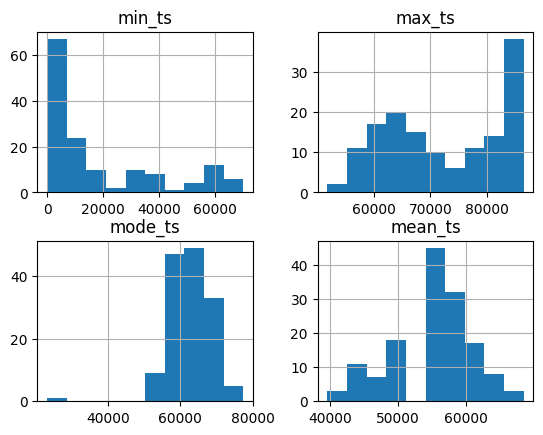

In [14]:
df_user_logoff_stats_sec.loc[df_user_log_result['anomaly_score'] < 0].hist()

In [20]:
# Lists to hold data from each file
connect_data = []
disconnect_data = []

# Iterate over each CSV file in the directory
for filename in os.listdir(csv_directory):
    if filename.endswith('.csv'):
        # Full path to the CSV file
        csv_path = os.path.join(csv_directory, filename)

        # Read the CSV file into a DataFrame
        df = pd.read_csv(csv_path, names=['User', 'Timestamp', 'PC', 'ActivityType', 'Action'])

        # Convert Timestamp to datetime
        df['Timestamp'] = pd.to_datetime(df['Timestamp'], format='%m/%d/%Y %H:%M:%S')

        # Filter DataFrame by action and append to the respective list
        connect_data.append(df[df['Action'] == 'Connect'])
        disconnect_data.append(df[df['Action'] == 'Disconnect'])

# Concatenate all connect and disconnect data into two separate DataFrames
connect_df = pd.concat(connect_data)
disconnect_df = pd.concat(disconnect_data)

# Split the data so that 80% is used for model training, 20% for testing
connect_train_df, connect_test_df = train_test_split(connect_df, test_size=0.2)
disconnect_train_df, disconnect_test_df = train_test_split(disconnect_df, test_size=0.2)


In [21]:
# Function to format datetime as H:M:S
format_time = lambda x: x.strftime('%H:%M:%S')

# Calculate means for connect and disconnect
connect_means = connect_train_df.groupby('User')['Timestamp'].apply(lambda x: format_time(x.mean()))
disconnect_means = disconnect_train_df.groupby('User')['Timestamp'].apply(lambda x: format_time(x.mean()))

# Calculate modes for connect and disconnect
# We use scipy's mode function which returns the first mode in case of multimodal data
connect_modes = connect_train_df.groupby('User')['Timestamp'].apply(lambda x: format_time(x.dt.time.mode()[0]))
disconnect_modes = disconnect_train_df.groupby('User')['Timestamp'].apply(lambda x: format_time(x.dt.time.mode()[0]))

# Convert Series to DataFrame for CSV output
connect_means_df = connect_means.reset_index().rename(columns={'Timestamp': 'Connect_mean_time'})
connect_modes_df = connect_modes.reset_index().rename(columns={'Timestamp': 'Connect_mode_time'})

disconnect_means_df = disconnect_means.reset_index().rename(columns={'Timestamp': 'Disconnect_mean_time'})
disconnect_modes_df = disconnect_modes.reset_index().rename(columns={'Timestamp': 'Disconnect_mode_time'})

# Create stats DataFrame for connection data
df_device_conn_stats = connect_train_df.groupby('User')['Timestamp'].agg(['min', 'max']).reset_index()
df_device_conn_stats['min'] = df_device_conn_stats['min'].dt.time.apply(format_time)
df_device_conn_stats['max'] = df_device_conn_stats['max'].dt.time.apply(format_time)

# Merge the mean and mode dataframes with the stats DataFrames
df_device_conn_stats = pd.merge(df_device_conn_stats, connect_means_df, on='User', how='left')
df_device_conn_stats = pd.merge(df_device_conn_stats, connect_modes_df, on='User', how='left')

# Rename the columns for consistency and clarity
df_device_conn_stats.rename(columns={'min': 'Connect_min_time',
                                     'max': 'Connect_max_time'}, inplace=True)

# Create stats DataFrame for disconnection data
df_device_disconn_stats = disconnect_train_df.groupby('User')['Timestamp'].agg(['min', 'max']).reset_index()
df_device_disconn_stats['min'] = df_device_disconn_stats['min'].dt.time.apply(format_time)
df_device_disconn_stats['max'] = df_device_disconn_stats['max'].dt.time.apply(format_time)

# Merge the mean and mode dataframes with the stats DataFrames
df_device_disconn_stats = pd.merge(df_device_disconn_stats, disconnect_means_df, on='User', how='left')
df_device_disconn_stats = pd.merge(df_device_disconn_stats, disconnect_modes_df, on='User', how='left')

# Rename the columns for consistency and clarity
df_device_disconn_stats.rename(columns={'min': 'Disconnect_min_time',
                                        'max': 'Disconnect_max_time'}, inplace=True)

# These variables hold the respective statistics for later use in your code:
# connect_means_df, connect_modes_df, disconnect_means_df, disconnect_modes_df

# Create stats DataFrame for connection data
df_device_conn_stats = connect_df.groupby('User')['Timestamp'].agg(['min', 'max']).reset_index()
df_device_conn_stats['min'] = df_device_conn_stats['min'].dt.time
df_device_conn_stats['max'] = df_device_conn_stats['max'].dt.time

# Merge the mean and mode dataframes with the stats DataFrames
df_device_conn_stats = pd.merge(df_device_conn_stats, connect_means_df, on='User', how='left')
df_device_conn_stats = pd.merge(df_device_conn_stats, connect_modes_df, on='User', how='left')

# Rename the columns for consistency and clarity
df_device_conn_stats.rename(columns={'min': 'Connect_min_time',
                                     'max': 'Connect_max_time',
                                     'Connect_mean_time': 'Connect_mean_time',
                                     'Connect_mode_time': 'Connect_mode_time'}, inplace=True)

# Create stats DataFrame for disconnection data
df_device_disconn_stats = disconnect_df.groupby('User')['Timestamp'].agg(['min', 'max']).reset_index()
df_device_disconn_stats['min'] = df_device_disconn_stats['min'].dt.time
df_device_disconn_stats['max'] = df_device_disconn_stats['max'].dt.time

# Merge the mean and mode dataframes with the stats DataFrames
df_device_disconn_stats = pd.merge(df_device_disconn_stats, disconnect_means_df, on='User', how='left')
df_device_disconn_stats = pd.merge(df_device_disconn_stats, disconnect_modes_df, on='User', how='left')

# Rename the columns for consistency and clarity
df_device_disconn_stats.rename(columns={'min': 'Disconnect_min_time',
                                        'max': 'Disconnect_max_time',
                                        'Disconnect_mean_time': 'Disconnect_mean_time',
                                        'Disconnect_mode_time': 'Disconnect_mode_time'}, inplace=True)


# Conversion of connection times to timestamps in seconds
for col in ['Connect_min_time', 'Connect_max_time', 'Connect_mode_time', 'Connect_mean_time']:
    # Convert the time strings to datetime.time objects
    df_device_conn_stats[col + '_ts'] = pd.to_datetime(df_device_conn_stats[col], format='%H:%M:%S').dt.time
    # Apply the dtt2timestamp function to convert to seconds
    df_device_conn_stats[col + '_sec'] = df_device_conn_stats[col + '_ts'].apply(dtt2timestamp)

# Conversion of disconnection times to timestamps in seconds
for col in ['Disconnect_min_time', 'Disconnect_max_time', 'Disconnect_mode_time', 'Disconnect_mean_time']:
    # Convert the time strings to datetime.time objects
    df_device_disconn_stats[col + '_ts'] = pd.to_datetime(df_device_disconn_stats[col], format='%H:%M:%S').dt.time
    # Apply the dtt2timestamp function to convert to seconds
    df_device_disconn_stats[col + '_sec'] = df_device_disconn_stats[col + '_ts'].apply(dtt2timestamp)

# Merge the connection and disconnection dataframes
df_device_full = pd.merge(df_device_conn_stats, df_device_disconn_stats, on='User')

# Select columns that end with '_sec' for analysis
sec_columns = [col for col in df_device_full.columns if col.endswith('_sec')]
device_full_array = df_device_full[sec_columns].values

In [22]:
accountant = BudgetAccountant(epsilon=0.1)

# Example usage:
iforest_custom = IsolationForestCustom(n_estimators=100, contamination=0.1, epsilon=0.1, accountant=accountant)
iforest_custom.fit(device_full_array)


In [23]:
# Function to format datetime as H:M:S
format_time = lambda x: x.strftime('%H:%M:%S')

# Calculate means for connect and disconnect
connect_means = connect_test_df.groupby('User')['Timestamp'].apply(lambda x: format_time(x.mean()))
disconnect_means = disconnect_test_df.groupby('User')['Timestamp'].apply(lambda x: format_time(x.mean()))

# Calculate modes for connect and disconnect
# We use scipy's mode function which returns the first mode in case of multimodal data
connect_modes = connect_test_df.groupby('User')['Timestamp'].apply(lambda x: format_time(x.dt.time.mode()[0]))
disconnect_modes = disconnect_test_df.groupby('User')['Timestamp'].apply(lambda x: format_time(x.dt.time.mode()[0]))

# Convert Series to DataFrame for CSV output
connect_means_df = connect_means.reset_index().rename(columns={'Timestamp': 'Connect_mean_time'})
connect_modes_df = connect_modes.reset_index().rename(columns={'Timestamp': 'Connect_mode_time'})

disconnect_means_df = disconnect_means.reset_index().rename(columns={'Timestamp': 'Disconnect_mean_time'})
disconnect_modes_df = disconnect_modes.reset_index().rename(columns={'Timestamp': 'Disconnect_mode_time'})

# Create stats DataFrame for connection data
df_device_conn_stats = connect_test_df.groupby('User')['Timestamp'].agg(['min', 'max']).reset_index()
df_device_conn_stats['min'] = df_device_conn_stats['min'].dt.time.apply(format_time)
df_device_conn_stats['max'] = df_device_conn_stats['max'].dt.time.apply(format_time)

# Merge the mean and mode dataframes with the stats DataFrames
df_device_conn_stats = pd.merge(df_device_conn_stats, connect_means_df, on='User', how='left')
df_device_conn_stats = pd.merge(df_device_conn_stats, connect_modes_df, on='User', how='left')

# Rename the columns for consistency and clarity
df_device_conn_stats.rename(columns={'min': 'Connect_min_time',
                                     'max': 'Connect_max_time'}, inplace=True)

# Create stats DataFrame for disconnection data
df_device_disconn_stats = disconnect_test_df.groupby('User')['Timestamp'].agg(['min', 'max']).reset_index()
df_device_disconn_stats['min'] = df_device_disconn_stats['min'].dt.time.apply(format_time)
df_device_disconn_stats['max'] = df_device_disconn_stats['max'].dt.time.apply(format_time)

# Merge the mean and mode dataframes with the stats DataFrames
df_device_disconn_stats = pd.merge(df_device_disconn_stats, disconnect_means_df, on='User', how='left')
df_device_disconn_stats = pd.merge(df_device_disconn_stats, disconnect_modes_df, on='User', how='left')

# Rename the columns for consistency and clarity
df_device_disconn_stats.rename(columns={'min': 'Disconnect_min_time',
                                        'max': 'Disconnect_max_time'}, inplace=True)

# These variables hold the respective statistics for later use in your code:
# connect_means_df, connect_modes_df, disconnect_means_df, disconnect_modes_df

# Create stats DataFrame for connection data
df_device_conn_stats = connect_df.groupby('User')['Timestamp'].agg(['min', 'max']).reset_index()
df_device_conn_stats['min'] = df_device_conn_stats['min'].dt.time
df_device_conn_stats['max'] = df_device_conn_stats['max'].dt.time

# Merge the mean and mode dataframes with the stats DataFrames
df_device_conn_stats = pd.merge(df_device_conn_stats, connect_means_df, on='User', how='left')
df_device_conn_stats = pd.merge(df_device_conn_stats, connect_modes_df, on='User', how='left')

# Rename the columns for consistency and clarity
df_device_conn_stats.rename(columns={'min': 'Connect_min_time',
                                     'max': 'Connect_max_time',
                                     'Connect_mean_time': 'Connect_mean_time',
                                     'Connect_mode_time': 'Connect_mode_time'}, inplace=True)

# Create stats DataFrame for disconnection data
df_device_disconn_stats = disconnect_df.groupby('User')['Timestamp'].agg(['min', 'max']).reset_index()
df_device_disconn_stats['min'] = df_device_disconn_stats['min'].dt.time
df_device_disconn_stats['max'] = df_device_disconn_stats['max'].dt.time

# Merge the mean and mode dataframes with the stats DataFrames
df_device_disconn_stats = pd.merge(df_device_disconn_stats, disconnect_means_df, on='User', how='left')
df_device_disconn_stats = pd.merge(df_device_disconn_stats, disconnect_modes_df, on='User', how='left')

# Rename the columns for consistency and clarity
df_device_disconn_stats.rename(columns={'min': 'Disconnect_min_time',
                                        'max': 'Disconnect_max_time',
                                        'Disconnect_mean_time': 'Disconnect_mean_time',
                                        'Disconnect_mode_time': 'Disconnect_mode_time'}, inplace=True)

# Conversion of connection times to timestamps in seconds
for col in ['Connect_min_time', 'Connect_max_time', 'Connect_mode_time', 'Connect_mean_time']:
    # Convert the time strings to datetime.time objects
    df_device_conn_stats[col + '_ts'] = pd.to_datetime(df_device_conn_stats[col], format='%H:%M:%S').dt.time
    # Apply the dtt2timestamp function to convert to seconds
    df_device_conn_stats[col + '_sec'] = df_device_conn_stats[col + '_ts'].apply(dtt2timestamp)

# Conversion of disconnection times to timestamps in seconds
for col in ['Disconnect_min_time', 'Disconnect_max_time', 'Disconnect_mode_time', 'Disconnect_mean_time']:
    # Convert the time strings to datetime.time objects
    df_device_disconn_stats[col + '_ts'] = pd.to_datetime(df_device_disconn_stats[col], format='%H:%M:%S').dt.time
    # Apply the dtt2timestamp function to convert to seconds
    df_device_disconn_stats[col + '_sec'] = df_device_disconn_stats[col + '_ts'].apply(dtt2timestamp)

# Merge the connection and disconnection dataframes
df_device_full = pd.merge(df_device_conn_stats, df_device_disconn_stats, on='User')
df_device_full = df_device_full.dropna()

# Select columns that end with '_sec' for analysis
sec_columns = [col for col in df_device_full.columns if col.endswith('_sec')]
device_full_array = df_device_full[sec_columns].values



In [24]:
# Use the trained model to predict anomaly scores for the test data
df_device_full['anomaly_score'] = iforest_custom.predict(device_full_array)

df_device_full_outliers = df_device_full[df_device_full['anomaly_score'] < 0]
print(df_device_full_outliers)

             User Connect_min_time Connect_max_time Connect_mean_time  \
51   DTAA/CTR0537         00:54:40         21:55:26          20:43:30   
142  DTAA/LKY0181         21:29:42         23:55:31          22:42:36   
191  DTAA/SAP0304         03:48:39         20:57:04          23:53:39   

    Connect_mode_time Connect_min_time_ts  Connect_min_time_sec  \
51           20:43:30            00:54:40                  3280   
142          21:29:42            21:29:42                 77382   
191          23:53:39            03:48:39                 13719   

    Connect_max_time_ts  Connect_max_time_sec Connect_mode_time_ts  ...  \
51             21:55:26                 78926             20:43:30  ...   
142            23:55:31                 86131             21:29:42  ...   
191            20:57:04                 75424             23:53:39  ...   

     Disconnect_mode_time Disconnect_min_time_ts  Disconnect_min_time_sec  \
51               05:24:54               03:17:19            

In [25]:
df_all = pd.DataFrame()

# Read all CSV files and concatenate into a single DataFrame
for filename in os.listdir(csv_directory):
    if filename.endswith('.csv'):
        file_path = os.path.join(csv_directory, filename)
        df_temp = pd.read_csv(file_path, header=None)  # Assuming the CSV has no header
        df_temp.columns = ['User', 'Timestamp', 'PC', 'Activity', 'Action']  # Assign column names
        df_all = pd.concat([df_all, df_temp])

# Ensure 'Timestamp' is a datetime object
df_all['Timestamp'] = pd.to_datetime(df_all['Timestamp'], format='%m/%d/%Y %H:%M:%S')

# Split the data so that 80% is used for model training, 20% for testing
df_train_all, df_test_all = train_test_split(df_all, test_size=0.2)

In [26]:
# Filter out 'Logon' and 'Logoff' activities into separate DataFrames
df_logon = df_train_all[df_train_all['Action'] == 'Logon']
df_logoff = df_train_all[df_train_all['Action'] == 'Logoff']

# Define a function to perform the aggregation and transformation
def aggregate_user_pc_log_activities(df_activity):
    # Aggregate data to count the total number of activities per user per PC
    df_user_pc = df_activity.groupby(['User', 'PC']).size().reset_index(name='pc_activities_per_user_total')

    # Calculate the unique count of PCs per user
    df_user_pc['unique_pc_count'] = df_user_pc.groupby('User')['PC'].transform('nunique')

    # Keep only the 'User' and 'unique_pc_count' columns and drop duplicates
    df_user_pc = df_user_pc[['User', 'unique_pc_count']].drop_duplicates()

    return df_user_pc

# Apply the function to both logon and logoff DataFrames
df_user_pc_logon = aggregate_user_pc_log_activities(df_logon)
df_user_pc_logoff = aggregate_user_pc_log_activities(df_logoff)

# Optionally, save these dataframes to CSV
# df_user_pc_logon.to_csv('user_pc_logon.csv', index=False)
# df_user_pc_logoff.to_csv('user_pc_logoff.csv', index=False)

In [27]:
df_user_pc_logon.sort_values('unique_pc_count')

,User,unique_pc_count
19861,DTAA/ZRR0705,1
13154,DTAA/JLV0465,1
13155,DTAA/JMA0875,1
13156,DTAA/JMC0233,1
18170,DTAA/RZW0369,1
...,...,...
12017,DTAA/JCC0998,810
7857,DTAA/DSM0990,818
8890,DTAA/ELD1000,818
14319,DTAA/KEE0997,837


In [28]:
# Train model 
pc_counts = np.array(df_user_pc_logon['unique_pc_count']).reshape(-1, 1)

accountant = BudgetAccountant(epsilon=0.1)

# Example usage:
iforest_custom = IsolationForestCustom(n_estimators=100, contamination=0.1, epsilon=0.1, accountant=accountant)
iforest_custom.fit(pc_counts)



In [29]:
# Filter out 'Logon' and 'Logoff' activities into separate DataFrames
df_logon = df_test_all[df_test_all['Action'] == 'Logon']
df_logoff = df_test_all[df_test_all['Action'] == 'Logoff']

# Define a function to perform the aggregation and transformation
def aggregate_user_pc_log_activities(df_activity):
    # Aggregate data to count the total number of activities per user per PC
    df_user_pc = df_activity.groupby(['User', 'PC']).size().reset_index(name='pc_activities_per_user_total')

    # Calculate the unique count of PCs per user
    df_user_pc['unique_pc_count'] = df_user_pc.groupby('User')['PC'].transform('nunique')

    # Keep only the 'User' and 'unique_pc_count' columns and drop duplicates
    df_user_pc = df_user_pc[['User', 'unique_pc_count']].drop_duplicates()

    return df_user_pc

# Apply the function to both logon and logoff DataFrames
df_user_pc_logon = aggregate_user_pc_log_activities(df_logon)
df_user_pc_logoff = aggregate_user_pc_log_activities(df_logoff)

# Optionally, save these dataframes to CSV
# df_user_pc_logon.to_csv('user_pc_logon.csv', index=False)
# df_user_pc_logoff.to_csv('user_pc_logoff.csv', index=False)

In [30]:
anomaly_scores = iforest_custom.predict(pc_counts)

In [31]:
import pickle

# Serialize the model using pickle
with open('user_pc_ct_isolation_forest.pkl', 'wb') as file:
    pickle.dump(iforest_custom, file)

# Create a DataFrame to hold the results
results = pd.DataFrame()
results['user'] = df_user_pc_logon['User']
results['unique_pc_count'] = df_user_pc_logon['unique_pc_count']
results['anomaly_score'] = anomaly_scores

# Identify potential outliers
# Outliers are defined as observations with an anomaly score less than 0
df_unique_pc_outliers = results.loc[results['anomaly_score'] < 0]

# Display the results
print(results.head(10))  # Show the first 10 results
print(df_unique_pc_outliers)          # Show the outliers

            user  unique_pc_count  anomaly_score
0   DTAA/AAA0371                5       0.025120
5   DTAA/AAC0344                1       0.027542
6   DTAA/AAC0599                1       0.027542
7   DTAA/AAH0734                1       0.027542
8   DTAA/AAK0658                1       0.027542
9   DTAA/AAK0924                1       0.027542
10  DTAA/AAR0508                1       0.027542
11  DTAA/AAS0709                2       0.025120
13  DTAA/ABB0272               19       0.020243
32  DTAA/ABD0833                1       0.027542
              user  unique_pc_count  anomaly_score
295   DTAA/ARS0993              341      -0.281940
793   DTAA/BJM0992              326      -0.292850
1368  DTAA/CGM0994              365      -0.303434
1819  DTAA/CLB0995              355      -0.281940
2178  DTAA/CLN0999              336      -0.287376
2554  DTAA/CRC0996              341      -0.281940
3188  DTAA/DSM0990              345      -0.303434
3617  DTAA/ELD1000              349      -0.303434
44

In [32]:
df_user_log_result.head()

df_threat_users_log = df_user_log_result.loc[df_user_log_result['anomaly_score'] <= -0.04]
print(df_threat_users_log)

             User  anomaly_score
24   DTAA/AFF0760      -0.066769
33   DTAA/AGW0182      -0.057461
215  DTAA/CLK0383      -0.061587
216  DTAA/CLN0999      -0.088766
230  DTAA/CRC0996      -0.041751
265  DTAA/DDK0417      -0.050767
293  DTAA/DSM0990      -0.073629
299  DTAA/DWF0128      -0.054279
325  DTAA/ELD1000      -0.040211
367  DTAA/GML0105      -0.054279
380  DTAA/GYT0279      -0.046730
443  DTAA/IRC0991      -0.046359
458  DTAA/JCC0998      -0.046359
519  DTAA/KEE0997      -0.040211
727  DTAA/OYR0801      -0.042414
849  DTAA/SHR0025      -0.048748
989  DTAA/ZAB0889      -0.045640


In [22]:
import matplotlib.pyplot as plt

/Users/aimee/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:7: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  import sys


             User Connect_min_time Connect_max_time Connect_mean_time  \
51   DTAA/CTR0537         00:54:40         21:55:26          20:43:30   
142  DTAA/LKY0181         21:29:42         23:55:31          22:42:36   
191  DTAA/SAP0304         03:48:39         20:57:04          23:53:39   

    Connect_mode_time Connect_min_time_ts  Connect_min_time_sec  \
51           20:43:30            00:54:40                  3280   
142          21:29:42            21:29:42                 77382   
191          23:53:39            03:48:39                 13719   

    Connect_max_time_ts  Connect_max_time_sec Connect_mode_time_ts  ...  \
51             21:55:26                 78926             20:43:30  ...   
142            23:55:31                 86131             21:29:42  ...   
191            20:57:04                 75424             23:53:39  ...   

     Disconnect_mode_time Disconnect_min_time_ts  Disconnect_min_time_sec  \
51               05:24:54               03:17:19            

,User,Connect_min_time,Connect_max_time,Connect_mean_time,Connect_mode_time,Connect_min_time_ts,Connect_min_time_sec,Connect_max_time_ts,Connect_max_time_sec,Connect_mode_time_ts,...,Disconnect_mode_time,Disconnect_min_time_ts,Disconnect_min_time_sec,Disconnect_max_time_ts,Disconnect_max_time_sec,Disconnect_mode_time_ts,Disconnect_mode_time_sec,Disconnect_mean_time_ts,Disconnect_mean_time_sec,anomaly_score
51,DTAA/CTR0537,00:54:40,21:55:26,20:43:30,20:43:30,00:54:40,3280,21:55:26,78926,20:43:30,...,05:24:54,03:17:19,11839,22:57:02,82622,05:24:54,19494.0,05:24:54,19494.0,-0.005458
142,DTAA/LKY0181,21:29:42,23:55:31,22:42:36,21:29:42,21:29:42,77382,23:55:31,86131,21:29:42,...,01:02:12,22:11:41,79901,00:04:44,284,01:02:12,3732.0,11:36:56,41816.0,-0.004074
191,DTAA/SAP0304,03:48:39,20:57:04,23:53:39,23:53:39,03:48:39,13719,20:57:04,75424,23:53:39,...,00:44:21,04:03:45,14625,21:51:23,78683,00:44:21,2661.0,19:02:58,68578.0,-0.002261


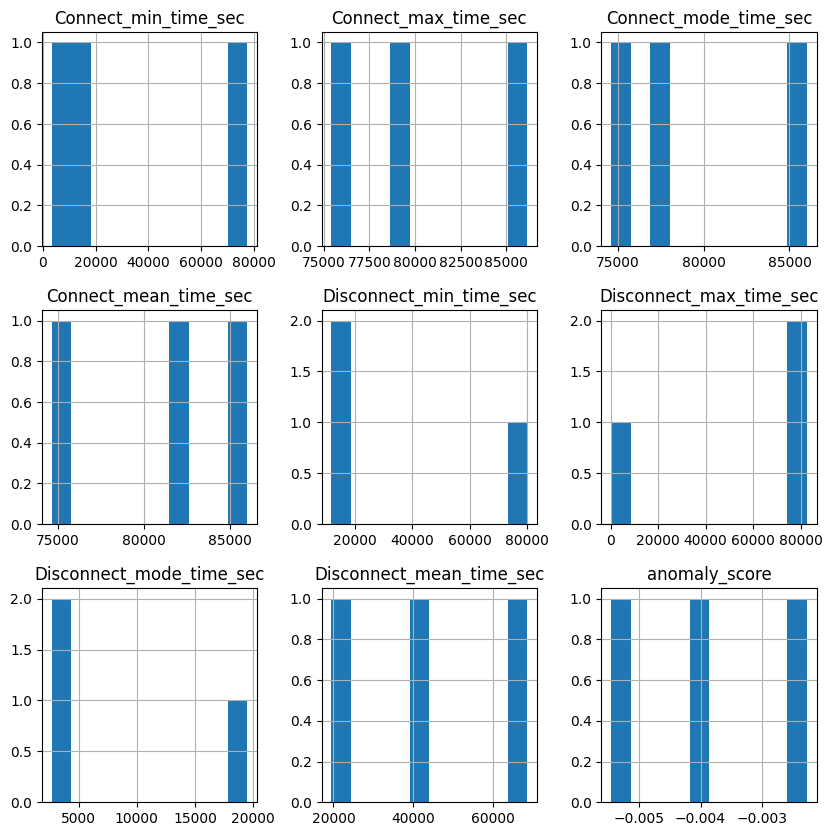

In [33]:
df_device_full_outliers.head()


fig = plt.figure(figsize=(10,10))
ax = fig.gca()

df_device_full_outliers.loc[df_device_full_outliers['anomaly_score'] < 0].hist(ax=ax)

df_threat_users_device_file = df_device_full_outliers.loc[df_device_full_outliers['anomaly_score'] <= 0]
print(df_threat_users_device_file)

df_device_full[df_device_full.User.isin(df_threat_users_device_file.User)]

/Users/aimee/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  after removing the cwd from sys.path.


              user  unique_pc_count  anomaly_score
295   DTAA/ARS0993              341      -0.281940
793   DTAA/BJM0992              326      -0.292850
1368  DTAA/CGM0994              365      -0.303434
1819  DTAA/CLB0995              355      -0.281940
2178  DTAA/CLN0999              336      -0.287376
2554  DTAA/CRC0996              341      -0.281940
3188  DTAA/DSM0990              345      -0.303434
3617  DTAA/ELD1000              349      -0.303434
4436  DTAA/IRC0991              335      -0.287376
4839  DTAA/JCC0998              317      -0.298361
5333  DTAA/JTT0989              327      -0.298361
5742  DTAA/KEE0997              358      -0.303434


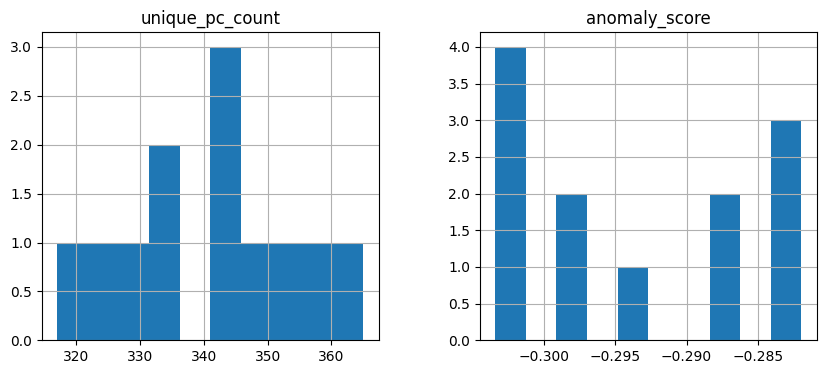

In [34]:
fig = plt.figure(figsize=(10,4))
ax = fig.gca()

df_unique_pc_outliers.loc[df_unique_pc_outliers['anomaly_score'] < 0].hist(ax=ax)

df_threat_users_unique_pc = df_unique_pc_outliers.loc[df_unique_pc_outliers['anomaly_score'] <= 0]
print(df_threat_users_unique_pc)